# DECISION TREE CLASSIFIER CODE FOR SHOPPING DATASET.

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
# Load and prepare the dataset
file_path = "D:\\NIT-J\\AI Lab\\Shopping 5th\\shopping.csv"
df = pd.read_csv(file_path)

In [33]:
# Convert categorical variables to numeric
df['Month'] = df['Month'].astype('category').cat.codes
df['VisitorType'] = df['VisitorType'].astype('category').cat.codes
df['Weekend'] = df['Weekend'].astype(int)
df['Revenue'] = df['Revenue'].astype(int)

# Define features (X) and target (y)
X = df.drop('Revenue', axis=1).values
y = df['Revenue'].values

# Train-test split function
def train_test_split(X, y, test_size=0.2):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    split = int(X.shape[0] * (1 - test_size))
    return X[indices[:split]], X[indices[split:]], y[indices[:split]], y[indices[split:]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define the Gini Impurity function
def gini_impurity(y):
    classes, counts = np.unique(y, return_counts=True)
    impurity = 1 - sum((count / len(y)) ** 2 for count in counts)
    return impurity

# Calculate weighted Gini Impurity for a split
def weighted_gini(left_y, right_y):
    left_weight = len(left_y) / (len(left_y) + len(right_y))
    right_weight = len(right_y) / (len(left_y) + len(right_y))
    return left_weight * gini_impurity(left_y) + right_weight * gini_impurity(right_y)

# Find the best split for a node
def best_split(X, y):
    best_gini = float("inf")
    best_feature, best_threshold = None, None
    for feature in range(X.shape[1]):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            left_mask = X[:, feature] <= threshold
            right_mask = X[:, feature] > threshold
            left_y, right_y = y[left_mask], y[right_mask]
            gini = weighted_gini(left_y, right_y)
            if gini < best_gini:
                best_gini = gini
                best_feature = feature
                best_threshold = threshold
    return best_feature, best_threshold

In [35]:
# Define a Node in the tree
class Node:
    def __init__(self, gini, num_samples, predicted_class):
        self.gini = gini
        self.num_samples = num_samples
        self.predicted_class = predicted_class
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None

# Recursive function to grow the tree
def grow_tree(X, y, depth=0, max_depth=5):
    num_samples_per_class = [np.sum(y == c) for c in np.unique(y)]
    predicted_class = np.argmax(num_samples_per_class)
    node = Node(
        gini=gini_impurity(y),
        num_samples=len(y),
        predicted_class=predicted_class,
    )
    if depth < max_depth and gini_impurity(y) > 0:
        feature, threshold = best_split(X, y)
        if feature is not None:
            node.feature_index = feature
            node.threshold = threshold
            left_mask = X[:, feature] <= threshold
            right_mask = X[:, feature] > threshold
            node.left = grow_tree(X[left_mask], y[left_mask], depth + 1, max_depth)
            node.right = grow_tree(X[right_mask], y[right_mask], depth + 1, max_depth)
    return node

# Prediction function for a single instance
def predict_single(node, x):
    while node.left and node.right:
        if x[node.feature_index] <= node.threshold:
            node = node.left
        else:
            node = node.right
    return node.predicted_class

# Prediction function for a batch of instances
def predict(tree, X):
    return np.array([predict_single(tree, x) for x in X])

# Train the decision tree
tree = grow_tree(X_train, y_train, max_depth=5)

# Make predictions on test data
y_pred = predict(tree, X_test)

# Evaluate accuracy
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9014598540145985


In [37]:

# Assuming you have the confusion matrix components
TP = np.sum((y_test == 1) & (y_pred == 1))  # True Positives
FP = np.sum((y_test == 0) & (y_pred == 1))  # False Positives
TN = np.sum((y_test == 0) & (y_pred == 0))  # True Negatives
FN = np.sum((y_test == 1) & (y_pred == 0))  # False Negatives

# Calculate metrics
accuracy = (TP + TN) / (TP + FP + TN + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
conf_matrix = confusion_matrix(y_test, y_pred)


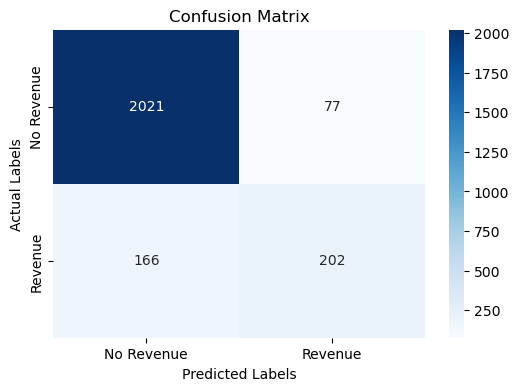

Accuracy: 0.9014598540145985

Precision: 0.7240143369175627

Recall: 0.5489130434782609

F1 Score: 0.624420401854714


In [39]:
# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Revenue', 'Revenue'], yticklabels=['No Revenue', 'Revenue'])
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

print("Accuracy:", accuracy)
print()
print("Precision:", precision)
print()
print("Recall:", recall)
print()
print("F1 Score:", f1_score)
